In [6]:
from functions import *
from random import sample
import json
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import dateparser
import random
import re
from pylab import *

In [7]:
base_path = "/media/ruben/Data Drive/react-data/protest/{}".format("carlo-batch-selection")

In [8]:
def PlotNER(ner, language, first_year,last_year,n,relative=True):
    
    print('Looking at {} in {}'.format(ner,language))
    print('{}-{}'.format(first_year,last_year))
    print('Taking the Top {} most frequent {}-entities'.format(n,ner))
    # Get Publication Dates

    dates_ref = dict()

    for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
        photo_folder = os.path.join(base_path, photo)
        with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
            x = f.readlines()
        dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

    # Get Entities
    ner_gpe = dict()

    for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
        photo_folder = os.path.join(base_path, photo)
        fn = os.path.join(photo_folder, "entities-" + photo + ".json")
        with open(fn) as fp:
            file = json.load(fp)

        for lan,items in file.items():
            if lan not in ner_gpe.keys():
                ner_gpe.update({lan:dict()})
            for id_,entities in items.items():
                if "brucelyonsblog" in id_:
                    continue
                    
                ll_entities = entities['entities']
                
                ner_entities = []
                
                for ner_item in ner:
                    tmp_ner_entities = [i[0] for i in ll_entities if i[-1] == ner_item and len(i[0]) > 2]
                    ner_entities += tmp_ner_entities
                if len(ner_entities) > 0:
                    ner_gpe[lan].update({id_:ner_entities})
    #return ner_gpe
    # Match Dates/Entities
    ner_df_dia = pd.DataFrame()
    for id_,locs in ner_gpe[language].items():

        id_ = id_.split('.html_')[-1]

        if id_ not in dates_ref.keys():
            continue

        date = dates_ref[id_][0:4]
        tmp = [[x,date,1] for x in locs]
        tmp = pd.DataFrame(tmp)
        ner_df_dia = ner_df_dia.append(tmp)
        
    ner_df_dia.columns = ['ent','year','count']
    
    ner_df_dia = ner_df_dia[ner_df_dia['ent'].isin([i[0] for i in Counter(list(ner_df_dia['ent'])).most_common(n)])]

    ner_df_dia = ner_df_dia.groupby(['ent','year']).sum().reset_index()
    ner_df_dia = ner_df_dia[(ner_df_dia['year'].astype(int) <= last_year) & (ner_df_dia['year'].astype(int) >= first_year)]
    ner_df_dia2 = ner_df_dia.pivot(index='ent',columns='year',values='count').reset_index()
    ner_df_dia2 = ner_df_dia2.fillna(0)

    if relative==True:

        for c in list(ner_df_dia2.columns)[1:]:
            sum_ = sum(ner_df_dia2[c].astype(int))
            ner_df_dia2[c] = ner_df_dia2[c] / sum_

        ner_df_dia2 = ner_df_dia2.melt(id_vars='ent')
        ner_df_dia2 = ner_df_dia2.pivot(index='year',columns='ent',values='value').reset_index()
#         p = ner_df_dia2.plot(x="year", y = list(ner_df_dia2.columns)[1:], kind="area", colormap = "tab20b", figsize=(20,10)).legend(bbox_to_anchor=(1, 1))
#         plt.title('Top {} {}-entities in {}-language webpages between {} and {}'.format(n,ner,language,first_year,last_year))
#         #plt.axis('off')
#         plt.show()
#         cmap = cm.get_cmap('tab20b', len(list(ner_df_dia2.columns)[1:]))    # PiYG
#         colors = []
#         for i in range(cmap.N):
#             rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#             colors.append(matplotlib.colors.rgb2hex(rgb))

#         plt.figure(figsize=(20, 10))

#         for c,city in enumerate(list(ner_df_dia2.columns)[1:]):
#             plt.bar(list(ner_df_dia2['year']), list(ner_df_dia2[city]), color=colors[c])

#         plt.legend(list(ner_df_dia2.columns)[1:], loc='upper right',fontsize=13)
#         plt.title('Top {} {}-entities in {}-language webpages between {} and {}'.format(n," & ".join(ner),language,first_year,last_year))
#         plt.xticks(np.arange(len(ner_df_dia2)), ner_df_dia2['year'], rotation=90)

    if relative == False:
        ner_df_dia2 = ner_df_dia2.melt(id_vars='ent')
        ner_df_dia2 = ner_df_dia2.pivot(index='year',columns='ent',values='value').reset_index()
        #ner_df_dia2['year'] = ner_df_dia2['year'].astype(int)
#         cmap = cm.get_cmap('tab20b', len(list(ner_df_dia2.columns)[1:]))    # PiYG
#         colors = []
#         for i in range(cmap.N):
#             rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#             colors.append(matplotlib.colors.rgb2hex(rgb))

#         plt.figure(figsize=(20, 10))

#         for c,city in enumerate(list(ner_df_dia2.columns)[1:]):
#             plt.bar(list(ner_df_dia2['year']), list(ner_df_dia2[city]), color=colors[c])

#         plt.legend(list(ner_df_dia2.columns)[1:], loc='upper right',fontsize=13)
#         plt.title('Top {} {}-entities in {}-language webpages between {} and {}'.format(n," & ".join(ner),language,first_year,last_year),size=16)
#         plt.xticks(np.arange(len(ner_df_dia2)), ner_df_dia2['year'], rotation=90)
    #fig = plt.get_figure()
    #fig.savefig('{}-{}-{}-{}-{}.png'.format("_".join(ner).lower(),language,first_year,last_year,n))
    #plt.show()
    df2 = pd.DataFrame()

    for i in list(ner_df_dia2.columns)[1:]:
        s = sum(ner_df_dia2[i])
        tmp = pd.DataFrame([i,s]).T
        df2 = df2.append(tmp)

    df2.columns = ['ent','c']
    df2 = df2.sort_values('c')
    return df2

Looking at ['LOC', 'GPE'] in en
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities
Looking at ['LOC', 'GPE'] in fr
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities
Looking at ['LOC', 'GPE'] in es
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities
Looking at ['LOC', 'GPE'] in it
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities


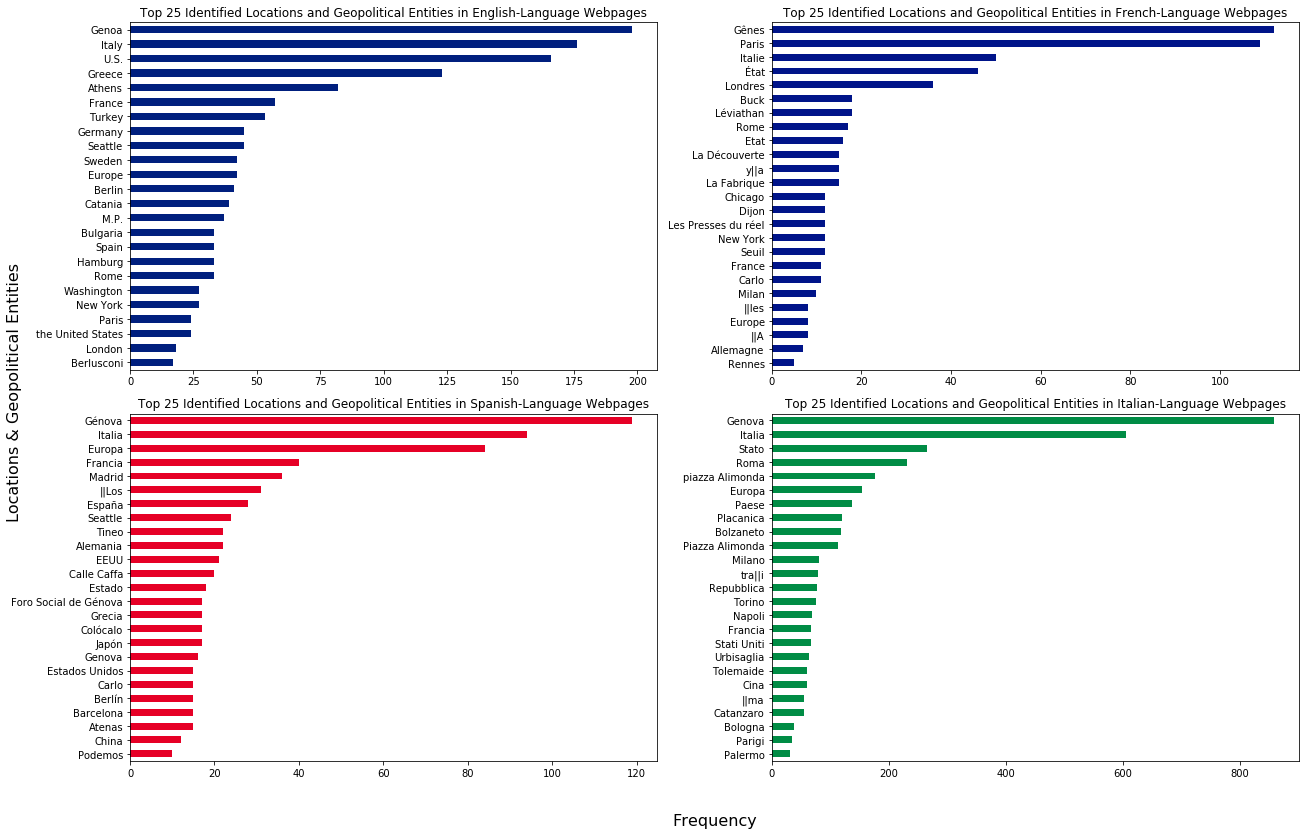

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(30,15))


df1 = PlotNER(["LOC","GPE"],"en",2003,2018,25,relative=False)
df1 = df1.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[0,0],title="Top 25 Identified Locations and Geopolitical Entities in English-Language Webpages",color="#001F7E")
df1.set_xlabel("")
df1.set_ylabel("")


df2 = PlotNER(["LOC","GPE"],"fr",2003,2018,25,relative=False)
df2 = df2.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[0,1],title="Top 25 Identified Locations and Geopolitical Entities in French-Language Webpages",color="#001489")
df2.set_xlabel("")
df2.set_ylabel("")

df3 = PlotNER(["LOC","GPE"],"es",2003,2018,25,relative=False)
df3 = df3.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[1,0],title="Top 25 Identified Locations and Geopolitical Entities in Spanish-Language Webpages",color="#e60026")
df3.set_xlabel("")
df3.set_ylabel("")

df4 = PlotNER(["LOC","GPE"],"it",2003,2018,25,relative=False)
df4 = df4.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[1,1],title="Top 25 Identified Locations and Geopolitical Entities in Italian-Language Webpages",color="#008C45")
df4.set_xlabel("")
df4.set_ylabel("")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Frequency",labelpad=35,fontsize= 16)
plt.ylabel("Locations & Geopolitical Entities",labelpad=85,fontsize= 16)
fig.tight_layout()

fig.savefig('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/ner-locations-en-fr-es-it-a.png',dpi=600)

In [15]:
def NERContext(language,word,window):
    print('Contextualizing {} in {}'.format(word,language))
    
    dates_ref = dict()

    for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
        photo_folder = os.path.join(base_path, photo)
        with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
            x = f.readlines()
        dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})
    
    
    d = []
    for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
        photo_folder = os.path.join(base_path, photo)
        fn = os.path.join(photo_folder, "entities-" + photo + ".json")
        with open(fn) as fp:
            file = json.load(fp)

        for lan,items in file.items():

            for id_,items2 in items.items():
                text = items2['text']
                url = id_.split("html_")[1]
                
                if url in dates_ref.keys():
                    date = dates_ref[url]
                else:
                    date = "unknown date"

                if len([i for i in items2['entities'] if i[0] == word]) != 0:
                    for i in [i for i in items2['entities'] if i[0] == word]:
                        w = text[i[1]-window:i[2]+window]
                        d.append([url,date,w])
    print('Year Frequencies top 5:', " | ".join([k+": "+str(v) for k,v in dict(Counter([i[1][0:4] for i in d if i[1] != "unknown date"]).most_common(5)).items()]))               
    d = pd.DataFrame(d,columns = ['url','date','window'])
    return d

In [16]:
df = NERContext('it','Europa',35)

Contextualizing Europa in it
Year Frequencies top 5: 2011: 94 | 2018: 39 | 2006: 30 | 2015: 25 | 2017: 22


In [17]:
df

,url,date,window
0,http://giovannimaiello.blogspot.com/2011/07/,2011--07,ronto alla guerra per difendere||l’Europa dall...
1,http://giovannimaiello.blogspot.com/2011/07/,2011--07,ronto alla guerra per difendere||l’Europa dall...
2,http://giovannimaiello.blogspot.com/2011/07/,2011--07,"all’Islam, l’accusa esplicita all’Europa di e..."
3,http://giovannimaiello.blogspot.com/2011/07/,2011--07,20% di 450 milioni di abitanti in Europa sign...
4,http://giovannimaiello.blogspot.com/2011/07/,2011--07,"ropa,||il progetto di Califfato in Europa, è s..."
...,...,...,...
311,http://www.forocomunista.com/t11767-10-anos-de...,2011-07-20,an la imperturbable voluntad de la Europa de a...
312,http://www.forocomunista.com/t11767-10-anos-de...,2011-07-20,vada lucha de clases contra los la Europa de a...
313,http://nordicanger.blogspot.com/2015/04/,2015--04,"presenta a la gentuza dominante en Europa, deb..."
314,http://dibattitomorsanese.blogspot.com/2011/11/,2011--11,"|rafforza il...\n||In cammino per l'Europa, Bo..."


In [73]:
df.to_csv('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/context-Israele-it.csv',index=False)

In [9]:
for i in df['window']:
    print(i)

nd the events now unfolding in the Ukraine ., The Cold War victory pursued an
Crimea and the invasion of eastern Ukraine the largest country outside of Fra
ectives are.
, That the borders of Ukraine were guaranteed by treaty signed b
he United Kingdom , Russia and the Ukraine back in 1994, seems to be totally 
gain it involved nuclear weapons., Ukraine would give them up if their territ
tanks are rolling ever deeper into Ukraine and President Obama continues to t
d forces pressing ever deeper into Ukraine., This is complicated by the prese
t poses to Moldova, to the west of Ukraine., Moldova is also a former republi
why the United States will not arm Ukraine militarily, because it might incit
with Syria, Iraq, Libya, Yemen and Ukraine already in the quagmire., Other na
outh Korea, Tonga, Turkey, Uganda, Ukraine, and Uzbekistan., [211] At least 1
outh Korea, Tonga, Turkey, Uganda, Ukraine, and Uzbekistan., [211] At least 1
outh Korea, Tonga, Turkey, Uganda, Ukraine, and Uzbekistan., [21

In [18]:
Counter(df['url']).most_common(5)

[('http://www.forocomunista.com/t11767-10-anos-de-la-muerte-de-carlo-giuliani',
  60),
 ('http://bellerofonte.blogspot.com/2006/', 21),
 ('http://giovannimaiello.blogspot.com/2011/07/', 15),
 ('https://wp.me/p8wIcm-3uA', 10),
 ('https://docplayer.it/106164744-Attenti-a-quei-due-n-75-agosto-2018.html',
  8)]